# 1.Introduction
这本笔记本的目的是说明一种处理时间序列预测问题的方法。我们将分析可用的时间序列数据，并讨论一些将完成这项工作的算法。我们将使用的数据来自“预测未来销售”（https://www.kaggle.com/c/competitive-data-science-predict-future-sales）。
我们得到了一家大型俄罗斯软件公司的一堆商店和产品的销售历史数据，任务是预测测试集的每个商店销售的产品总量。

# 2.Quick look at the data
让我们导入所有必要的库并读取csv文件：

kaggle比赛中的数据描述:
为您提供每日历史销售数据。任务是预测测试集的每个商店销售的产品总量。请注意，商店和产品列表每月都会略有变化。创建一个能够处理这种情况的健壮模型是挑战的一部分。

文件描述:
sales_train.csv: 训练集。2013年1月至2015年10月的每日历史数据。
test.csv: 测试集。您需要预测这些商店和产品在2015年11月的销售额。
sample_submission.csv: 格式正确的示例提交文件。
item.csv: 有关项目/产品的补充信息。
item_categories.csv: 有关项目类别的补充信息。
shop.csv: 关于商店的补充信息。

数据字段:
ID：表示测试集中的（Shop， Item）元组的ID
shop_id：商店的唯一标识符
item_id：产品的唯一标识符
item_category_id：项目类别的唯一标识符
item_cnt_day：销售的产品数量。您正在预测此指标的每月金额
item_price：项目的当前价格
日期：格式为dd/mm/yyyy的日期
date_block_num：连续的月份数字，用于方便。2013年1月为0,2013年2月为1，…，2015年10月为33
item_name：项目名称
shop_name：店铺名称
item_category_name：项目类别名称

In [44]:
from platform import python_version
print(python_version())

3.10.12


In [45]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt 
import seaborn as sns 

from math import sqrt
from sklearn.metrics import mean_squared_error
from matplotlib.pylab import rcParams


# TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas import Timestamp
from datetime import datetime

#MODELLING
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
# settings
import os
import gc
import warnings
warnings.filterwarnings("ignore")

In [46]:
# 让我们导入数据：
folder='./competitive-data-science-predict-future-sales/'

df_cats=pd.read_csv(folder+'item_categories.csv')
df_items=pd.read_csv(folder+'items.csv')
df_sales=pd.read_csv(folder+'sales_train.csv')
df_shops=pd.read_csv(folder+'shops.csv')
df_test=pd.read_csv(folder+'test.csv')

#pickles
folder_pickles='./competitive-data-science-predict-future-sales/pickles/'

#Submission
df_sub=pd.read_csv(folder+'sample_submission.csv')
sub_folder='./competitive-data-science-predict-future-sales/submissions/'

In [47]:
# 让我们定义以下函数以获取数据框的快速摘要
def overview(df):
    print('SHAPE:\n',df.shape)
    print('COLUMN NAMES:\n', df.columns.tolist())
    print('UNIQUE VALUES PER COLUMN:\n', df.nunique())
    print('COLUMNS WITH MISSING DATA:\n',df.isnull().sum())
    print('SAMPLE:\n',df.sample(10))
    print('INFO:\n',df.info())

## 2.1 sales_train

In [48]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [49]:
overview(df_sales)

SHAPE:
 (2935849, 6)
COLUMN NAMES:
 ['date', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
UNIQUE VALUES PER COLUMN:
 date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64
COLUMNS WITH MISSING DATA:
 date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
SAMPLE:
                date  date_block_num  shop_id  item_id  item_price  \
1805378  17.07.2014              18       35    11498      499.00   
1216403  30.12.2013              11       57    16947      349.00   
2395891  04.01.2015              24       59    12440      332.67   
297130   15.03.2013               2        6    19405      999.00   
1986465  07.09.2014              20       24     4181     1190.00   
2353557  25.01.2015              24       24     2946      449.00   
940140   11.10.2013               9       42    

In [50]:
sorted(list(df_sales["item_cnt_day"].unique()))[:20]

[-22.0,
 -16.0,
 -9.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0]

In [51]:
sorted(list(df_sales["item_price"].unique()))[:20]

[-1.0,
 0.07,
 0.0875,
 0.09,
 0.1,
 0.2,
 0.5,
 0.908713692946,
 0.99,
 1.0,
 1.83,
 2.0,
 2.99,
 3.0,
 3.57,
 3.59,
 3.64,
 3.67,
 3.69,
 3.71]

In [52]:
df_sales[df_sales["item_price"]<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [53]:
# 处理异常值，处理shop表中售卖价格为负的数据，用一些均值替代
mean = df_sales[(df_sales["shop_id"] == 32) & (df_sales["item_id"] == 2973) & (df_sales["date_block_num"] == 4) & (df_sales["item_price"] > 0)]["item_price"].mean()
df_sales.loc[df_sales.item_price < 0, 'item_price'] = mean

In [54]:
# =============================================================================
# CLEANING DF_SALES
# =============================================================================

# 这个地方是因为这几个shop_id：0 1 10 代表的地方在训练集合中没有，但是在观实中，比较靠近57，58，11所在的地区，所以作者直接把值改过去了
# Якутск Орджоникидзе, 56
df_sales.loc[df_sales.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_sales.loc[df_sales.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_sales.loc[df_sales.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

#create attribute revenue
df_sales['revenue']=df_sales['item_price']*df_sales['item_cnt_day']

<Axes: xlabel='item_cnt_day'>

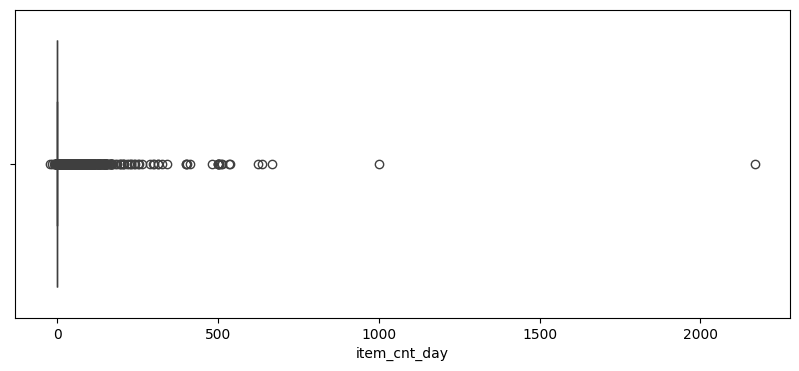

In [55]:
# 让我们寻找异常值
plt.figure(figsize = (10,4))
sns.boxplot(x = df_sales["item_cnt_day"])

In [56]:
# 从名为 df_sales 的数据框中选择满足条件 item_cnt_day > 800 的行。
df_sales[df_sales['item_cnt_day']>800]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
2326930,15.01.2015,24,12,20949,4.000000,1000.0,4000.0
2909818,28.10.2015,33,12,11373,0.908714,2169.0,1971.0


<Axes: xlabel='item_price'>

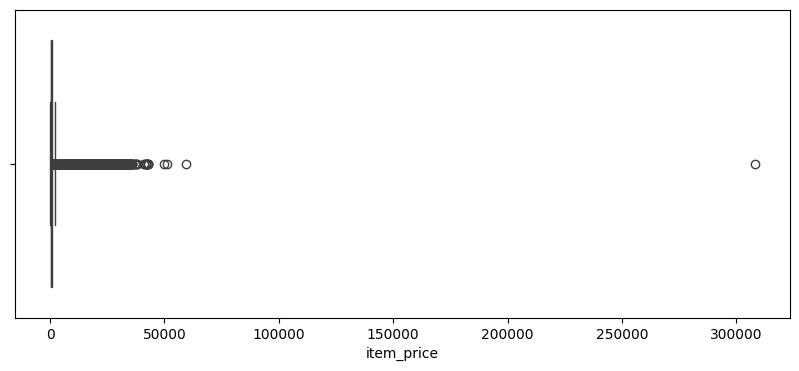

In [57]:
plt.figure(figsize = (10,4))
sns.boxplot(x = df_sales["item_price"])

In [58]:
# 从名为 df_sales 的数据框中选择满足条件 item_price > 800 的行。
df_sales[df_sales['item_price']>100000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
1163158,13.12.2013,11,12,6066,307980.0,1.0,307980.0


In [59]:
# 从名为 df_sales 的数据框中选择满足条件 item_price < 300000 和 item_cnt_day < 1000 的行
df_sales = df_sales[(df_sales.item_price < 300000 )& (df_sales.item_cnt_day < 1000)]

## 2.2 items

In [60]:
df_items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [61]:
overview(df_items)

SHAPE:
 (22170, 3)
COLUMN NAMES:
 ['item_name', 'item_id', 'item_category_id']
UNIQUE VALUES PER COLUMN:
 item_name           22170
item_id             22170
item_category_id       84
dtype: int64
COLUMNS WITH MISSING DATA:
 item_name           0
item_id             0
item_category_id    0
dtype: int64
SAMPLE:
                                                item_name  item_id  \
15458  Мягкая игрушка СОЮЗМУЛЬТФИЛЬМ Чебурашка малый ...    15458   
838    1С:Управляющий. Управленческий учет для директ...      838   
262    1С:Аудиокниги. Кириллов К., Обердерфер Д. Как ...      262   
15750                           НИМФОМАНКА: ЧАСТЬ 2 (BD)    15750   
538        1С:Образование 5. Школа [PC, Цифровая версия]      538   
6890                           TURUNEN TARJA  Act 1  2CD     6890   
13220  Комикс The Sandman Песочный человек Том 1 Прел...    13220   
6825             THE DOORS  Live At The Bowl 68  Blu-Ray     6825   
1829   Battlefield 3 Premium. Сборник дополнений (код...     1829 

In [62]:
# 将显示的最大行数设置为 100。这意味着当你打印（或者显示）一个数据框时，最多会显示 100 行。
pd.options.display.max_rows=100
# 使用 groupby 函数对 df_items 数据框按照 item_category_id 列进行分组。然后，使用 agg 函数对每个组进行聚合操作。
# 在这里，使用了 {'item_id': 'count'} 参数，表示对每个组的 item_id 列进行计数操作，得到每个类别中的物品数量。
gb_item_cat=df_items.groupby('item_category_id').agg({'item_id':'count'})
# ascending=False 参数，表示按降序进行排序，即物品数量从大到小排序。
# inplace=True 参数表示对原始的 gb_item_cat 数据框进行就地排序，而不是创建一个新的排序后的副本。
gb_item_cat.sort_values('item_id',ascending=False,inplace=True)
# gb_item_cat

## 2.3 item_categories

In [63]:
df_cats.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [64]:
overview(df_cats)

SHAPE:
 (84, 2)
COLUMN NAMES:
 ['item_category_name', 'item_category_id']
UNIQUE VALUES PER COLUMN:
 item_category_name    84
item_category_id      84
dtype: int64
COLUMNS WITH MISSING DATA:
 item_category_name    0
item_category_id      0
dtype: int64
SAMPLE:
                      item_category_name  item_category_id
34         Карты оплаты - Live! (Цифра)                34
68        Подарки - Сертификаты, услуги                68
43                   Книги - Аудиокниги                43
12                Игровые консоли - PS4                12
31                      Игры PC - Цифра                31
80                   Служебные - Билеты                80
81              Чистые носители (шпиль)                81
37                       Кино - Blu-Ray                37
44           Книги - Аудиокниги (Цифра)                44
56  Музыка - CD фирменного производства                56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns)

In [65]:
# df_cats

In [66]:
# =============================================================================
# CLEANING DF_CATS
# =============================================================================
# 它们似乎由一个类型和子类型组成，由“-”分隔… blablabla…
# 根据 'item_category_name' 列的值，使用 '-' 进行拆分，并提取拆分结果中的第一个元素，然后赋值给新创建的 'cat_type' 列
df_cats['cat_type'] = df_cats['item_category_name'].str.split('-').map(lambda x: x[0])
# 根据 'item_category_name' 列的值，使用 '-' 进行拆分，并根据拆分结果的长度选择赋值给新创建的 'cat_subtype' 列。
# 如果拆分结果的长度大于 1，则取拆分结果中的第二个元素作为值，否则取拆分结果中的第一个元素作为值。
df_cats['cat_subtype'] = df_cats['item_category_name'].str.split('-').map(lambda x: x[1] if len(x)>1 else x[0])
# 使用 LabelEncoder 对 'cat_type' 列进行编码，将不同的类别映射为整数编码，并将编码结果赋值给新创建的 'cat_type_id' 列。
df_cats['cat_type_id']=LabelEncoder().fit_transform(df_cats['cat_type'])
# 使用 LabelEncoder 对 'cat_subtype' 列进行编码，将不同的类别映射为整数编码，并将编码结果赋值给新创建的 'cat_subtype_id' 列。
df_cats['cat_subtype_id']=LabelEncoder().fit_transform(df_cats['cat_subtype'])
# 重新排列 df_cats 数据框的列的顺序，只保留 'item_category_id', 'cat_type_id', 'cat_subtype_id' 这三列。
df_cats=df_cats[['item_category_id','cat_type_id','cat_subtype_id']]

## 2.4 shops

In [67]:
df_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [68]:
overview(df_shops)

SHAPE:
 (60, 2)
COLUMN NAMES:
 ['shop_name', 'shop_id']
UNIQUE VALUES PER COLUMN:
 shop_name    60
shop_id      60
dtype: int64
COLUMNS WITH MISSING DATA:
 shop_name    0
shop_id      0
dtype: int64
SAMPLE:
                                 shop_name  shop_id
34                   Н.Новгород ТРЦ "РИО"       34
38                         Омск ТЦ "Мега"       38
30                 Москва ТЦ "Перловский"       30
10             Жуковский ул. Чкалова 39м?       10
36  Новосибирск ТРЦ "Галерея Новосибирск"       36
18                   Красноярск ТЦ "Июнь"       18
9                       Выездная Торговля        9
56                   Чехов ТРЦ "Карнавал"       56
57                Якутск Орджоникидзе, 56       57
19                  Курск ТЦ "Пушкинский"       19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id

In [69]:
df_shops.sort_values('shop_name',ascending=False)

,shop_name,shop_id
59,"Ярославль ТЦ ""Альтаир""",59
58,"Якутск ТЦ ""Центральный""",58
57,"Якутск Орджоникидзе, 56",57
56,"Чехов ТРЦ ""Карнавал""",56
55,Цифровой склад 1С-Онлайн,55
54,"Химки ТЦ ""Мега""",54
53,"Уфа ТЦ ""Семья"" 2",53
52,"Уфа ТК ""Центральный""",52
51,"Тюмень ТЦ ""Зеленый Берег""",51
50,"Тюмень ТЦ ""Гудвин""",50


In [70]:
# =============================================================================
# CLEANING DF_SHOP
# =============================================================================

# 这个城市的名字似乎是店名的第一个单词。我们看到一些错别字，比如 "! Якутск" 而不是 "Якутск" ，
# 还有一些店名似乎是重复的: "Жуковский ул. Чкалова 39м²"和 "Жуковский ул. Чкалова 39м？"。我们在准备数据时会记住这一点。

# 根据 'shop_name' 列的值，使用空格进行拆分，并提取拆分结果中的第一个元素，然后赋值给新创建的 'city' 列。
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
# 将 '!Якутск' 这个特殊的城市名称替换为 'Якутск'，以修正数据中的错误。
df_shops.loc[df_shops.city=='!Якутск','city']='Якутск'
# 使用 LabelEncoder 对 'city' 列进行编码，将不同的城市名称映射为整数编码，并将编码结果赋值给新创建的 'city_id' 列。
df_shops['city_id']=LabelEncoder().fit_transform(df_shops['city'])
# 根据 'shop_name' 列的值，使用空格进行拆分，并提取拆分结果中的第二个元素，然后赋值给新创建的 'cat_tienda' 列。
df_shops['cat_tienda'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[1])
# 创建一个空列表
category = []
# 遍历 'cat_tienda' 列中的唯一值。
for cat in df_shops.cat_tienda.unique():
    # 如果 'cat_tienda' 列中某个值在数据框中出现的次数大于等于 5 次。
    if len(df_shops[df_shops.cat_tienda == cat]) >= 5:
        # 将满足条件的 'cat_tienda' 值添加到 category 列表中。
        category.append(cat)
# 使用 apply 方法，将 'cat_tienda' 列中的值替换为 'other'，如果该值不属于 category 列表。
df_shops.cat_tienda = df_shops.cat_tienda.apply( lambda x: x if (x in category) else "other" )
# 使用 LabelEncoder 对 'cat_tienda' 列进行编码，将不同的类别映射为整数编码，并将编码结果赋值给新创建的 'shop_cat' 列。
df_shops['shop_cat']=LabelEncoder().fit_transform(df_shops['cat_tienda'])
# 重新排列 df_shops 数据框的列的顺序，只保留 'city', 'shop_id', 'city_id', 'shop_cat' 这四列。
df_shops=df_shops[['city','shop_id','city_id','shop_cat']]

## 2.5 test

In [71]:
df_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [72]:
overview(df_test)

SHAPE:
 (214200, 3)
COLUMN NAMES:
 ['ID', 'shop_id', 'item_id']
UNIQUE VALUES PER COLUMN:
 ID         214200
shop_id        42
item_id      5100
dtype: int64
COLUMNS WITH MISSING DATA:
 ID         0
shop_id    0
item_id    0
dtype: int64
SAMPLE:
             ID  shop_id  item_id
200550  200550       44    11365
80675    80675       15     5834
58375    58375       25    16042
31307    31307       11    14477
163595  163595       36    20192
211680  211680       45     1538
166824  166824       36     8260
196880  196880       41      413
186323  186323       34     2036
46024    46024       31     9407
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB
INFO:
 None


## 2.6 sample_submission

In [73]:
df_sub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [74]:
overview(df_sub)

SHAPE:
 (214200, 2)
COLUMN NAMES:
 ['ID', 'item_cnt_month']
UNIQUE VALUES PER COLUMN:
 ID                214200
item_cnt_month         1
dtype: int64
COLUMNS WITH MISSING DATA:
 ID                0
item_cnt_month    0
dtype: int64
SAMPLE:
             ID  item_cnt_month
75252    75252             0.5
89959    89959             0.5
136075  136075             0.5
193959  193959             0.5
211976  211976             0.5
210075  210075             0.5
64027    64027             0.5
74216    74216             0.5
15545    15545             0.5
60069    60069             0.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB
INFO:
 None


In [75]:
# 'item_cnt_month' 是要删除的列的名称。
# axis=1 表示删除列，因为 1 是表示列的轴。
# inplace=True 表示对原始数据框进行就地修改，即不创建一个新的副本，而是直接修改 df_sub 数据框本身。
df_sub.drop('item_cnt_month',axis=1,inplace=True)  

# 3.Dealing with the time variable
我们有一个date_block_num变量，它给我们提供了ts的每月分段。无论如何，我们都会重新格式化日期列，以便能够在必要时每天、每周和每年重新取样日期：

In [76]:
# 使用 pd.to_datetime() 函数将名为 'date' 的列转换为日期时间格式。
df_sales["date"] = pd.to_datetime(df_sales["date"], format = "%d.%m.%Y")
# 将转换后的日期时间列设置为数据框的索引，即将 'date' 列作为索引列。
df_sales.set_index('date')

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
date,,,,,,
2013-01-02,0,59,22154,999.00,1.0,999.00
2013-01-03,0,25,2552,899.00,1.0,899.00
2013-01-05,0,25,2552,899.00,-1.0,-899.00
2013-01-06,0,25,2554,1709.05,1.0,1709.05
2013-01-15,0,25,2555,1099.00,1.0,1099.00
...,...,...,...,...,...,...
2015-10-10,33,25,7409,299.00,1.0,299.00
2015-10-09,33,25,7460,299.00,1.0,299.00
2015-10-14,33,25,7459,349.00,1.0,349.00


In [77]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2935846 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   revenue         float64       
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 179.2 MB


# 4.EDA

In [78]:
# 将 df_sales 和 df_shops 这两个数据框根据 'shop_id' 列进行左连接（left join）操作，并将结果赋值给 full_df 数据框。
full_df=pd.merge(df_sales,df_shops,on=['shop_id'],how='left')
# 将上一步得到的 full_df 数据框与 df_items 数据框根据 'item_id' 列进行左连接操作，并将结果再次赋值给 full_df 数据框。
full_df=pd.merge(full_df,df_items,on=['item_id'],how='left')
# 将上一步得到的 full_df 数据框与 df_cats 数据框根据 'item_category_id' 列进行左连接操作，并将最终结果赋值给 full_df 数据框。
full_df=pd.merge(full_df,df_cats,on=['item_category_id'],how='left')

## 4.1 Total sales per month

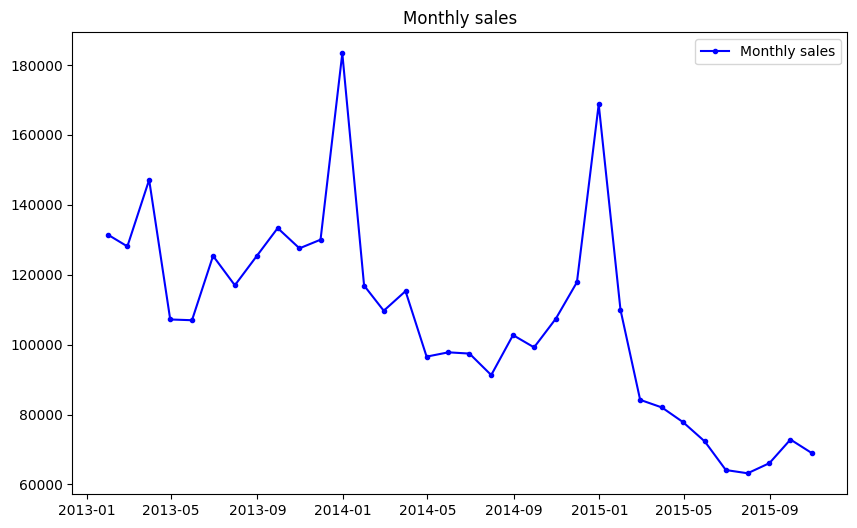

In [79]:
# 从 full_df 数据框中选择 "date" 和 "item_cnt_day" 两列，设置 "date" 列为索引，并使用 resample() 方法按月进行重采样，
# 并对 "item_cnt_day" 列进行求和操作。将结果赋值给 ts_M 变量，表示按月汇总的销售量时间序列数据。
ts_M = full_df[["date", "item_cnt_day"]].set_index("date").resample("M").sum()
# 创建一个图形窗口，并指定图形的大小为 10x6 英寸。
plt.figure(figsize = (10, 6))
# 绘制折线图，其中 x 轴为时间索引，y 轴为月度销售量。使用蓝色的线条表示，并在每个数据点上绘制小圆点作为标记。
plt.plot(ts_M, color = "blue", label = "Monthly sales",marker='.')
# 设置图形的标题为 "Monthly sales"。
plt.title("Monthly sales")
# 显示图例，其中包含标签为 "Monthly sales" 的条目。
plt.legend()

我们已经可以看到总销售额随着时间的推移而下降，并且有一个明显的年度季节性模式，在圣诞节前后出现高峰值。
## 4.2 Total sales per week

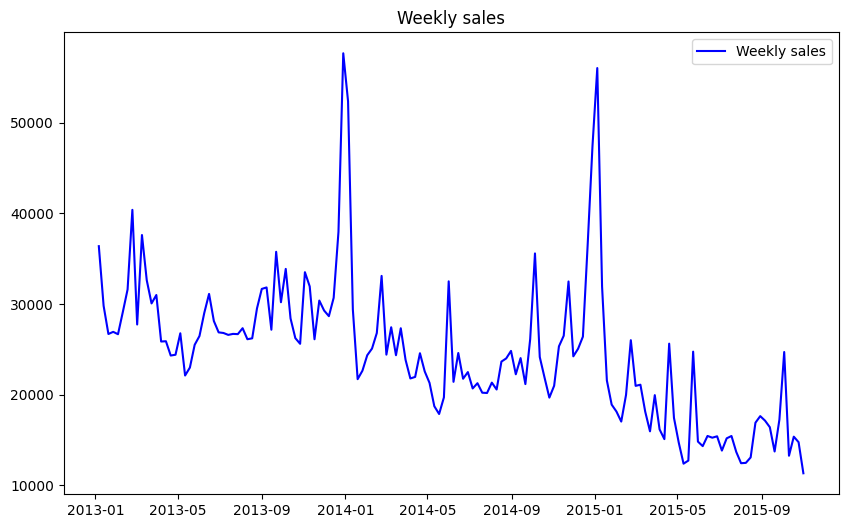

In [80]:
# 从 full_df 数据框中选择 "date" 和 "item_cnt_day" 两列，设置 "date" 列为索引，并使用 resample() 方法按周进行重采样，
# 并对 "item_cnt_day" 列进行求和操作。将结果赋值给 ts_W 变量，表示按周汇总的销售量时间序列数据。
ts_W = full_df[["date", "item_cnt_day"]].set_index("date").resample("W").sum()

plt.figure(figsize = (10, 6))
plt.plot(ts_W, color = "blue", label = "Weekly sales")
plt.title("Weekly sales")
plt.legend()

## 4.3 Total sales per month and shop

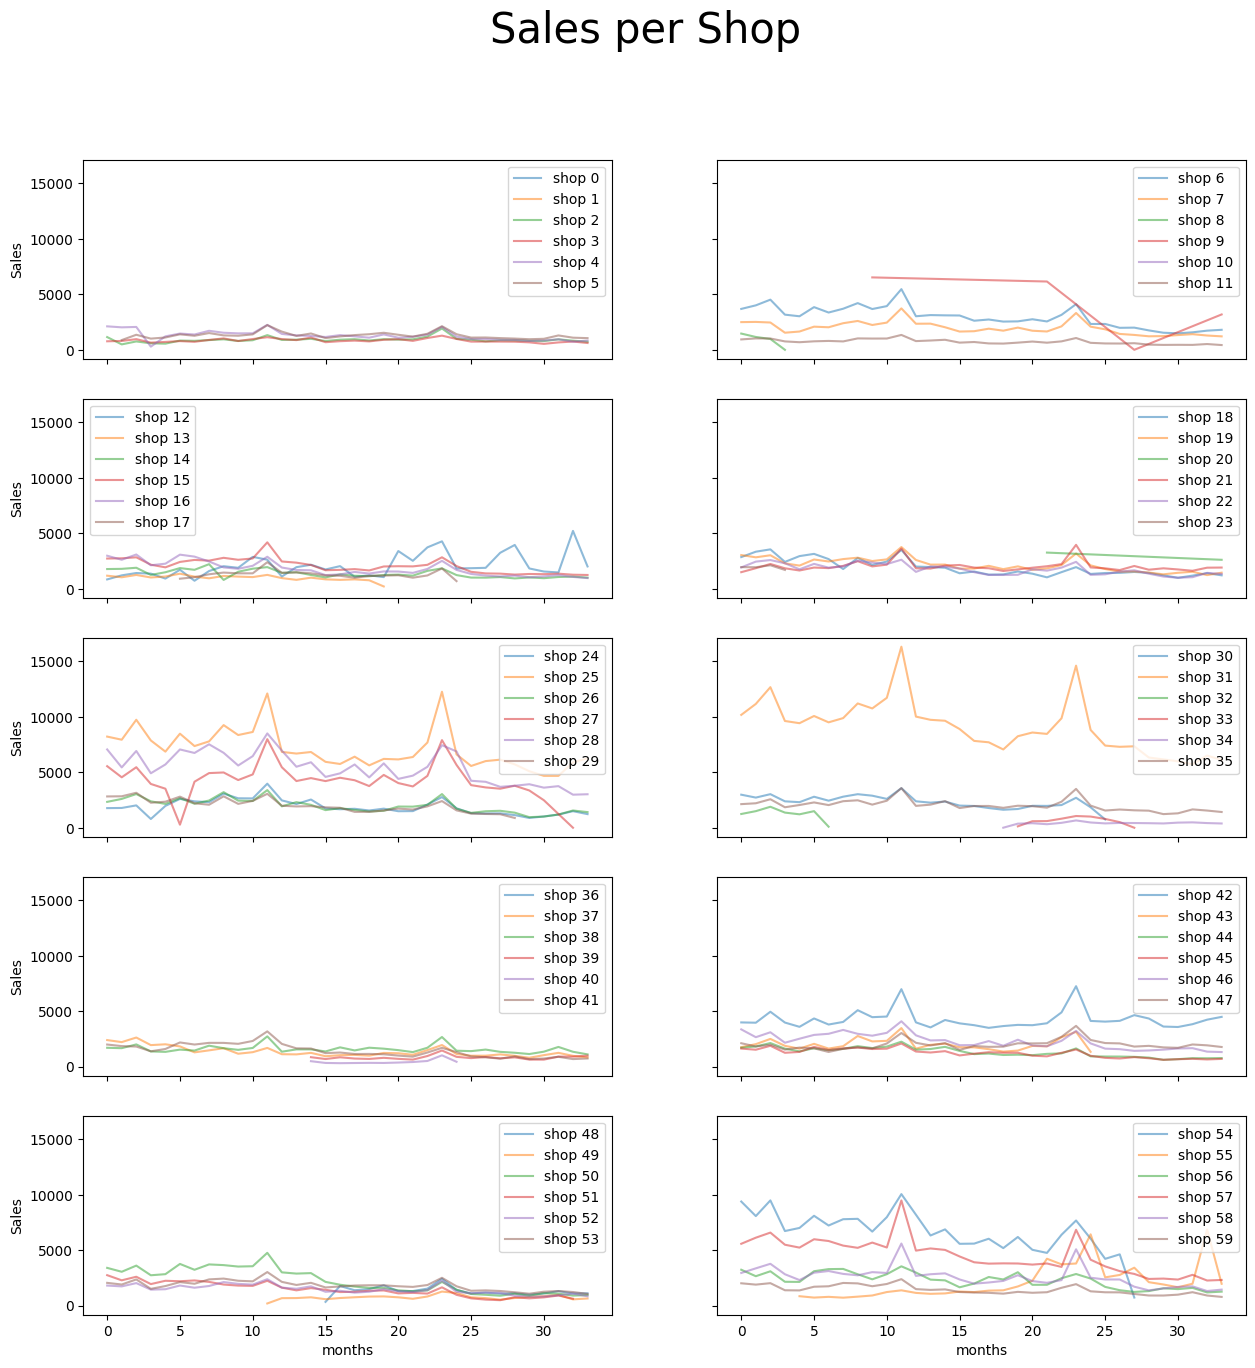

In [81]:
# 创建一个包含 5 行 2 列的子图网格，共计 10 个子图，并共享 x 轴和 y 轴。
# 指定图形的大小为 15x15 英寸。fig 是整个图形对象，ax 是一个包含所有子图的数组。
fig,ax = plt.subplots(nrows=5, ncols=2,sharex=True, sharey=True,figsize=(15,15))
# 设置图形的总标题为 "Sales per Shop"，字体大小为 30。
fig.suptitle('Sales per Shop', fontsize=30)
# 对合并后的数据框 full_df 进行分组操作，按照 'shop_id' 和 'date_block_num' 列进行分组，并对 'item_cnt_day' 列进行求和。
# 最后，通过 reset_index() 方法将分组后的结果重新设置为数据框。
ts_shop = full_df.groupby(['shop_id','date_block_num'])['item_cnt_day'].sum().reset_index()
# 初始化 shop_count 变量为 0，用于迭代每个商店的销售量数据。
shop_count=0
# 嵌套的循环用于遍历子图网格的行和列。
for i in range(5):
    for j in range(2):
        # 循环用于遍历每个商店的销售量数据。
        for z in range(6):
            # 在当前子图 ax[i, j] 上绘制商店 shop_count 的销售量数据。使用透明度为 0.5 的线条绘制，并指定标签为 'shop ' + str(shop_count)。
            ax[i,j].plot(ts_shop[ts_shop['shop_id']==shop_count]['date_block_num'],ts_shop[ts_shop['shop_id']==shop_count]['item_cnt_day'],alpha=.5,label='shop '+str(shop_count))
            # 将 shop_count 值加 1，以便绘制下一个商店的销售量数据。
            shop_count += 1
            # 在当前子图上显示图例，位于最佳位置。
            ax[i,j].legend(loc='best')
# 通过循环遍历所有的子图。
for ax in ax.flat:
    # 设置每个子图的 x 轴标签为 "months"，y 轴标签为 "Sales"。
    ax.set(xlabel='months', ylabel='Sales')
    # 隐藏子图网格中多余的轴标签，只显示最外围的轴标签。
    ax.label_outer()

## 4.4 Total sales per month and category

[Text(0.5, 0, 'item category'), Text(0, 0.5, 'Sales')]

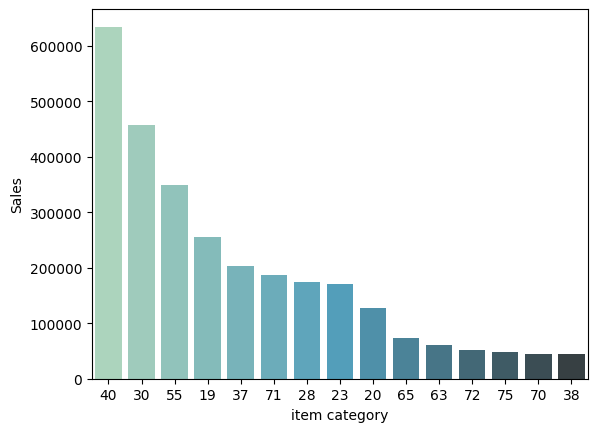

In [82]:
# 对合并后的数据框 full_df 按照 'item_category_id' 列进行分组，并对 'item_cnt_day' 列进行求和，得到每个商品类别的总销售量。
items_x_cat=full_df.groupby('item_category_id').agg({'item_cnt_day':'sum'})
# 将分组后的结果重新设置为数据框，并重置索引。
items_x_cat.reset_index(inplace=True)
# 按照销售量降序对商品类别进行排序。
items_x_cat=items_x_cat.sort_values('item_cnt_day',ascending=False)
# 选择销售量排名前15的商品类别。
items_x_cat_top=items_x_cat[0:15]
# 将商品类别的数据类型转换为对象类型，以便在条形图中正确显示类别标签。
items_x_cat_top['item_category_id']=items_x_cat_top['item_category_id'].astype(object)
# 重置商品类别的索引，去除原有的索引列。
items_x_cat_top=items_x_cat_top.reset_index(drop=True)
# 使用 Seaborn 库绘制条形图。指定 y 轴为销售量，x 轴为商品类别，调色板为 'GnBu_d'，数据来源为 items_x_cat_top 数据框，同时根据销售量降序对商品类别进行排序。
barplot=sns.barplot(y='item_cnt_day',x='item_category_id',palette='GnBu_d',data=items_x_cat_top,order=items_x_cat_top.sort_values('item_cnt_day',ascending=False).item_category_id)
# 设置 x 轴标签为 "item category"，y 轴标签为 "Sales"。
barplot.set(xlabel="item category", ylabel = "Sales")

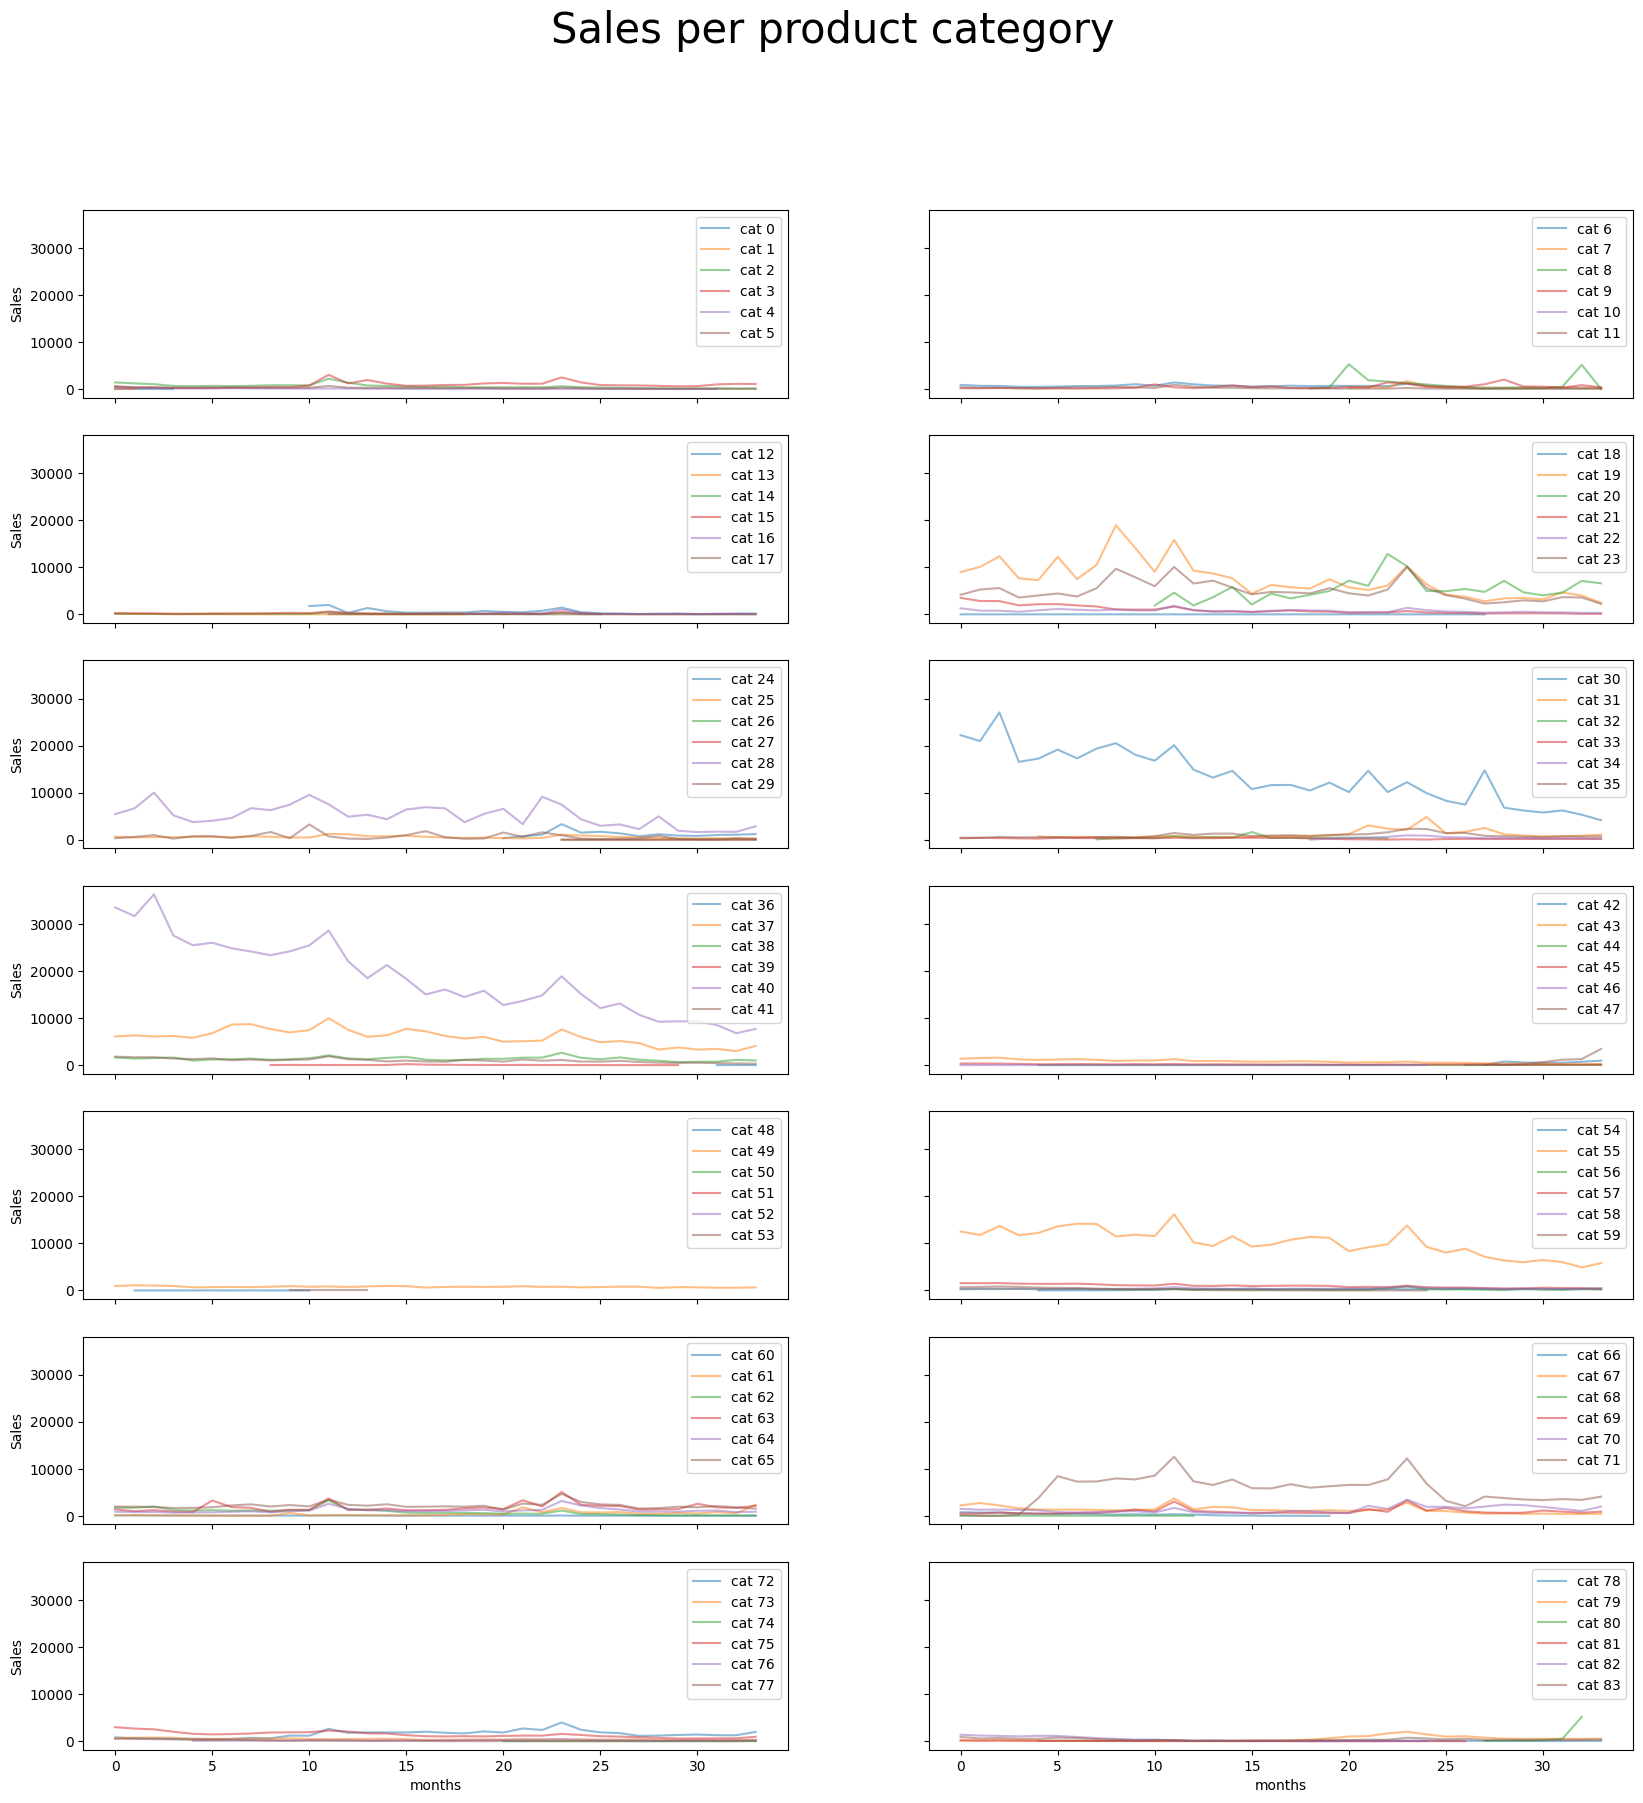

In [83]:
# 类似于Total sales per month and shop中的处理
fig,ax = plt.subplots(nrows=7, ncols=2,sharex=True, sharey=True,figsize=(20,20))
fig.suptitle('Sales per product category', fontsize=30)
ts_cat = full_df.groupby(['item_category_id','date_block_num'])['item_cnt_day'].sum().reset_index()
cat_count=0
for i in range(7):
    for j in range(2):
        for z in range(6):
            ax[i,j].plot(ts_cat[ts_cat['item_category_id']==cat_count]['date_block_num'],ts_cat[ts_cat['item_category_id']==cat_count]['item_cnt_day'],alpha=.5,label='cat '+str(cat_count))
            cat_count += 1
            ax[i,j].legend(loc='best')

for ax in ax.flat:
    ax.set(xlabel='months', ylabel='Sales')
    ax.label_outer()